<a href="https://colab.research.google.com/github/TraktylCo/Using-Recurrent-NN/blob/master/PM_ESCIM19_DB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***
Nombre de modelo: PM_ESCIM19_DB3 \\
Fecha: 20 Oct. 2019 \\
***

Modelo con dos redes neuronales para detección de tipos de palabra y suejeto/predicado

Principales cambios con respecto al modelo original:
- Optimizador RMSprop
- Reemplazo CuDNNLSTM por CuDNNGRU: Utilizamos celdas GRU en lugar de LSTM, con lo que se pretende obtener resultados similares con un menor tiempo de entrenamiento. 
- Se ha añadido el guardado de los diccionarios de palabras y etiquetas, al igual que de los grupos de entrenamiento y test.
- El entrenamiento de las redes ahora se base en "online/incremental learning" con lo cual utilizamos sequencias de tamaño variable. (Batch size = 1)

***

Se utilizan dos redes neuronales

La primera se entrena para identificar tipos de palabras en frases
- Datos de entrada: Las palabras de la frase // Salida: Etiquetas de cada palabra (verbo, determinante, etc.)

La segunda red se entrena para identificar las frases que forman parte del sujeto y del predicado, dados los tipos de palabras de la frase 
- Datos entrada: Etiquetas de las palabras // Salida: Etiquetas de sujeto y predicado para cada palabra

In [0]:
# Mount GDrive Data

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Read dataset & build data variables

import time
import nltk
from nltk.corpus import BracketParseCorpusReader

# Time (Code snippet from StackOverflow user: Mr. B)

intervals = (
    ('weeks', 604800),  # 60 * 60 * 24 * 7
    ('days', 86400),    # 60 * 60 * 24
    ('hours', 3600),    # 60 * 60
    ('minutes', 60),
    ('seconds', 1),
    )

def display_time(seconds, granularity=2):
    result = []

    for name, count in intervals:
        value = seconds // count
        if value:
            seconds -= value * count
            if value == 1:
                name = name.rstrip('s')
            result.append("{} {}".format(value, name))
    return ', '.join(result[:granularity])

# Import dataset from drive directory
corpus_root = r"/content/gdrive/My Drive/datasets/PennTreeBank/"
file_pattern = r'.*\.mrg'
ptb = BracketParseCorpusReader(corpus_root, file_pattern)

# Import parsed sentences from the corpus
sentences = ptb.parsed_sents()

print("Total sentences: ", len(sentences))

# Global variables
input_X = [[] for x in range(len(sentences))] # Save sentences words
input_Y = [[] for x in range(len(sentences))] # Save sentences tags
tag = ""
buff = ""
count = 0

# Recursive iteration through NLTK Trees
def iterate_tree(sent):
    
    global tag
  
    if not tag.endswith("_"):
        tag += "_"
    
    buff = str(sent.label())
    buff = buff.split("-")[0]

    tag += buff + "_"
    buff = ""
    
    for tok in sent:
        if type(tok) is nltk.tree.Tree:
            iterate_tree(tok)
        elif type(tok) is str:
            input_X[count].append(tok)
            input_Y[count].append(tag.split('_')[1:-1])
        
        tag = tag.split('_')
        tag = tag[:-1]
        tag = '_'.join(tag)

for sentence in sentences:
    iterate_tree(sentence)
    tag = ""
    count += 1

# Delete sentences with less than two words 
for i in reversed(range(len(input_X))):
    if (len(input_X[i]) < 2) or (len(input_Y[i]) < 2):
        input_X.pop(i)
        input_Y.pop(i)

print(len(input_X))
print(len(input_Y))

print("Finished!")

Bad tree detected; trying to recover...
  Recovered by returning a flat parse.
Bad tree detected; trying to recover...
  Recovered by returning a flat parse.
Bad tree detected; trying to recover...
  Recovered by returning a flat parse.


Total sentences:  6139


Bad tree detected; trying to recover...
  Recovered by returning a flat parse.
Bad tree detected; trying to recover...
  Recovered by returning a flat parse.
Bad tree detected; trying to recover...
  Recovered by returning a flat parse.


5637
5637
Finished!


In [0]:
# Clean tags splitted by "="

for i, sentence in enumerate(input_Y):
    for j, wtag in enumerate(sentence):
        for k, tag in enumerate(wtag):
          if(tag.find('=') != -1):
            tag = tag.split('_')
            tag = tag[:-1]
            input_Y[i][j][k]=str(tag)

In [0]:
# Delete empty elements

for i in reversed(range(len(input_Y))):
  for j in reversed(range(len(input_Y[i]))):
    for k in reversed(range(len(input_Y[i][j]))):
      if not input_Y[i][j][k]:
        input_Y[i][j].pop(k)

In [0]:
# Read dataset & build data variables

splitters = [",", ".", ":"]

sentences = [[]]
tags = [[]]

count = 0
for i, sentence in enumerate(input_X):
  for j, word in enumerate(sentence):
    if word in splitters:
      sentences.append(list())
      tags.append(list())
      count += 1
    else:
      sentences[count].append(word)
      tags[count].append(input_Y[i][j])

In [0]:
  # Delete words that start with * or - 

for i in reversed(range(len(sentences))):
  for j in reversed(range(len(sentences[i]))):
      if sentences[i][j][0] == "*" or sentences[i][j][0] == "-" or sentences[i][j][0] == "<":
        sentences[i].pop(j)
        tags[i].pop(j)

In [0]:
# Delete elements with only one tag

for i in reversed(range(len(tags))):
  for j in reversed(range(len(tags[i]))):
      if len(tags[i][j]) < 2:
        tags[i].pop(j)
        tags[i].pop(j)

In [0]:
# Make sure every sentence starts with 'S' tag

for i, sentence in enumerate(tags):
    for j, wtag in enumerate(sentence):
      if tags[i][j][0] != 'S':
        tags[i][j].insert(0,'S')

In [0]:
for i in reversed(range(len(sentences))):
  if len(sentences[i]) < 2:
      sentences.pop(i)
      tags.pop(i)

print(len(sentences))
print(len(tags))

8381
8381


In [0]:
# 1st NN training data (POS tags)
import copy

training_1stNN = copy.deepcopy(tags)

for i, sentence in enumerate(training_1stNN):
    for j, wtag in enumerate(sentence):
      training_1stNN[i][j] = training_1stNN[i][j][-1]

In [0]:
# 2nd NN training data (NP & VP)
training_2ndNN = [[] for _ in range(len(tags))]

sentences_2nd = copy.deepcopy(training_1stNN)

for i, sentence in enumerate(tags):
    for j, word in enumerate(sentence):
      for k, tag in enumerate(word):
        if tag == "NP" or tag == "VP":
          training_2ndNN[i].append(tag)
          break
      
      try:
        training_2ndNN[i][j]
      except:
        training_2ndNN[i].append("-PAD-")

for i in reversed(range(len(training_2ndNN))):
  for j in reversed(range(len(training_2ndNN[i]))):
    if training_2ndNN[i][j] == "-PAD-":
      training_2ndNN[i].pop(j)
      sentences_2nd[i].pop(j)

for i in reversed(range(len(training_2ndNN))):
  if len(training_2ndNN[i]) < 2:
      sentences_2nd.pop(i)
      training_2ndNN.pop(i)

print(len(sentences_2nd))
print(len(training_2ndNN))

8109
8109


In [0]:
print(len(sentences))
print(len(training_1stNN))

8381
8381


In [0]:
# Create words and tags dictionaries using Keras Tokenizer

import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
import numpy as np

w = Tokenizer()
p = Tokenizer()
t = Tokenizer()

# Words dictionary
w.fit_on_texts(sentences)
w.word_index['-PAD-'.lower()] = 0

word_index = w.word_index
np.save('word_index_db3.npy', word_index)

# 1st NN training
p.fit_on_texts(training_1stNN)
p.word_index['-PAD-'.lower()] = 0

pos_index = p.word_index
np.save('pos_index_db3.npy', pos_index)

# 2nd NN training
t.fit_on_texts(training_2ndNN)
t.word_index['-PAD-'.lower()] = 0

sp_index = t.word_index
np.save('sp_index_db3.npy', sp_index)

print("Finished!")

Finished!


In [0]:
sub = 0
pre = 0
pad = 0
count = 0

for sentence in training_2ndNN:
  for word in sentence:
    count += 1
    if word == "NP":
      sub += 1
    elif word == "VP":
      pre += 1
    else:
      pad += 1

In [0]:
print("Subject tags: ", sub)
print("Predicate tags: ", pre)
print("Pad tags: ", pad)
print("Total: ", count)
print("Sum: ", sub+pre+pad)

Subject tags:  18175
Predicate tags:  66980
Pad tags:  6881
Total:  92036
Sum:  92036


In [0]:
# ************************************************************
# ****************  1st Neural Network ***********************
# ************************************************************

from sklearn.model_selection import train_test_split

np.save('sentences_db3.npy', sentences)
np.save('trainint_1stNN_db3.npy', training_1stNN)

train_sentences, test_sentences, train_pos, test_pos = train_test_split(sentences, training_1stNN, shuffle=True, test_size=0.3, random_state=5)

np.save('train_sentences_db3.npy', train_sentences)
np.save('test_sentences_db3.npy', test_sentences)
np.save('train_pos_db3.npy', train_pos)
np.save('test_pos_db3.npy', test_pos)

train_enc_sent, test_enc_sent = [], []
train_enc_pos, test_enc_pos = [], []

for s in train_sentences:
    train_enc_sent.append([word_index[word.lower()] for word in s])

for s in test_sentences:
    test_enc_sent.append([word_index[word.lower()] for word in s])     
                
for s in train_pos:
    train_enc_pos.append([pos_index[word.lower()] for word in s])

for s in test_pos:
    test_enc_pos.append([pos_index[word.lower()] for word in s])

In [0]:
# Import pre-trained GloVe Word-Vectors (To use in Keras Embedding layer)

import os
import numpy as np

embeddings_index = {}
f = open(os.path.join('/content/gdrive/My Drive/datasets/glove.6B.100d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

EMBEDDING_DIM = 100

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [0]:
# Neural Network Architecture

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import *
from tensorflow.python.keras import backend as K

model1 = Sequential()
#model.add(InputLayer(input_shape=(None, 1))) # Bug when load_model() is called in Keras 2.2.X 
model1.add(Lambda(lambda model1: K.batch_flatten(model1), input_shape=(None, 1)))
model1.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False))
model1.add(Bidirectional(CuDNNGRU(128, return_sequences=True)))
model1.add(Dropout(0.15))
model1.add(TimeDistributed(Dense(len(pos_index))))
model1.add(Activation("softmax"))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Compile model

import tensorflow as tf
from tensorflow.python.keras.optimizers import RMSprop

model1.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['sparse_categorical_accuracy'])

print("Keras version: ", tf.keras.__version__)
print("Tensorflow version: ", tf.__version__)
model1.summary()

Keras version:  2.2.4-tf
Tensorflow version:  1.15.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         1023000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         176640    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 53)          13621     
_________________________________________________________________
activation (Activation)      (None, None, 53)          0         
Total params: 1,213,261
Trainable params: 190,261
Non-trainable param

In [0]:
# Prepare training data

# Convert data to numpy array
train_enc_sent = np.array(train_enc_sent)
train_enc_pos = np.array(train_enc_pos)

for i, v in enumerate(train_enc_sent):
    v = np.array(v)
    train_enc_sent[i] = v
    
for i, v in enumerate(train_enc_pos):
    v = np.array(v)
    train_enc_pos[i] = v

# Show data shape (it only shows first dimension, since the others are different for each sequence)
print(train_enc_sent.shape)
print(train_enc_pos.shape)

for i in range(len(train_enc_sent)):
  train_enc_sent[i] = train_enc_sent[i].reshape(1, len(train_enc_sent[i]), 1)
  train_enc_pos[i] = train_enc_pos[i].reshape(1, len(train_enc_pos[i]), 1)

for i in range(len(train_enc_sent)):
  train_enc_sent[i] = np.array(train_enc_sent[i])
  train_enc_pos[i] = np.array(train_enc_pos[i])

(5866,)
(5866,)


In [0]:
# Prepare test data

# Convert data to numpy array
test_enc_sent = np.array(test_enc_sent)
test_enc_pos = np.array(test_enc_pos)

for i, v in enumerate(test_enc_sent):
    v = np.array(v)
    test_enc_sent[i] = v
    
for i, v in enumerate(test_enc_pos):
    v = np.array(v)
    test_enc_pos[i] = v

# Show data shape (it only shows first dimension, since the others are different for each sequence)
print(test_enc_sent.shape)
print(test_enc_pos.shape)

for i in range(len(test_enc_sent)):
  test_enc_sent[i] = test_enc_sent[i].reshape(1, len(test_enc_sent[i]), 1)
  test_enc_pos[i] = test_enc_pos[i].reshape(1, len(test_enc_pos[i]), 1)

for i in range(len(test_enc_sent)):
  test_enc_sent[i] = np.array(test_enc_sent[i])
  test_enc_pos[i] = np.array(test_enc_pos[i])

(2515,)
(2515,)


In [0]:
# Fit the model
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

acc_log = []
loss_log = []

acc_test = []
loss_test = []

start = time.time()

for epoch in range(25):
    print("Epoch ", epoch+1, end='')
    startl = time.time()

    history = [model1.fit(seq, label, verbose=0) for seq, label in zip(train_enc_sent, train_enc_pos)] 

    scores = [model1.evaluate(seq, label, verbose=0) for seq, label in zip(test_enc_sent, test_enc_pos)]

    x, y = [], []

    for i in range(len(history)):
      x.append(history[i].history['sparse_categorical_accuracy'][0])
      y.append(history[i].history['loss'][0])
      
    acc = sum(x) / len(history)
    acc_log.append(acc)

    lss = sum(y) / len(history)
    loss_log.append(lss)

    print(" - sparse_categorical_accuracy: ", acc, end='')
    print(" - loss: ", lss, end='')

    x, y = [], []

    for i in range(len(scores)):
      x.append(scores[i][1])
      y.append(scores[i][0])
      
    acct = sum(x) / len(scores)
    acc_test.append(acct)

    lsst = sum(y) / len(scores)
    loss_test.append(lsst)

    print(" - test sparse_categorical_accuracy: ", acct, end='')
    print(" - test loss: ", lsst, end='')

    endl = time.time()        
    elapsed_time = endl-startl
    print(", Elapsed time: ", display_time(elapsed_time))

end = time.time()
elapsed_time = end-start
print("Elapsed time: ", display_time(elapsed_time))

# Save Model
model1.save('PM_ESCIM19_DB3_N1.h5')
np.save('acc_log_n1_db3.npy', acc_log)
np.save('loss_log_n1_db3.npy', loss_log)
np.save('acc_test_n1_db3.npy', acc_test)
np.save('loss_test_n1_db3.npy', loss_test)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10167218079351557406
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15902434084315395385
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2029764343278960712
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3103439668989706639
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
Epoch  1WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as

['loss', 'sparse_categorical_accuracy']
dict_keys(['loss', 'sparse_categorical_accuracy'])


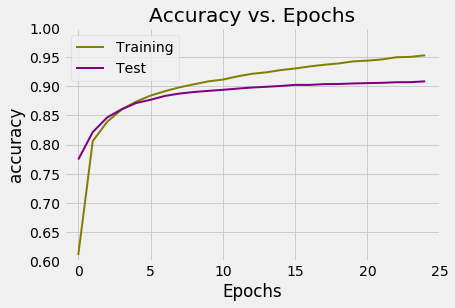

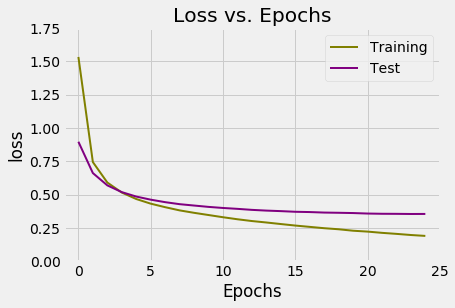

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

print(model1.metrics_names)
plt.style.use('fivethirtyeight')

# Train accuracy
print(history[0].history.keys())

plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('accuracy')


plt.axis([-1, len(acc_log), 0.6, 1])
plt.plot(range(len(acc_log)), acc_log, color='olive', linewidth=2, label="Training")
plt.plot(range(len(acc_test)), acc_test, color='purple', linewidth=2, label="Test")
plt.legend()
plt.show()

print()

# Train loss
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

plt.axis([-1, len(loss_log), 0, 1.75])
plt.plot(range(len(loss_log)), loss_log, color='olive', linewidth=2, label="Training")
plt.plot(range(len(loss_test)), loss_test, color='purple', linewidth=2, label="Test")
plt.legend()
plt.show()

In [0]:
sentences_2nd[0]

['December',
 '1998',
 'Your',
 'contribution',
 'to',
 'Goodwill',
 'will',
 'mean',
 'more',
 'than',
 'you',
 'may',
 'know']

In [0]:
# ************************************************************
# ****************  2nd Neural Network ***********************
# ************************************************************

from sklearn.model_selection import train_test_split

np.save('sentences_2nd_db3.npy', sentences_2nd)
np.save('trainint_2ndNN_db3.npy', training_2ndNN)

train_pos_2nd, test_pos_2nd, train_sp, test_sp = train_test_split(sentences_2nd, training_2ndNN, shuffle=True, test_size=0.3, random_state=5)

np.save('train_pos_2nd_db3.npy', train_pos_2nd)
np.save('test_pos_2nd_db3.npy', test_pos_2nd)
np.save('train_sp_db3.npy', train_sp)
np.save('test_sp_db3.npy', test_sp)

train_enc_pos_2nd, test_enc_pos_2nd = [], []
train_enc_sp, test_enc_sp = [], []

for s in train_pos_2nd:
    train_enc_pos_2nd.append([pos_index[word.lower()] for word in s])

for s in test_pos_2nd:
    test_enc_pos_2nd.append([pos_index[word.lower()] for word in s])     
                
for s in train_sp:
    train_enc_sp.append([sp_index[word.lower()] for word in s])

for s in test_sp:
    test_enc_sp.append([sp_index[word.lower()] for word in s])

In [0]:
# 2nd Neural Network Architecture

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import *
from tensorflow.python.keras import backend as K

model2 = Sequential()
#model.add(InputLayer(input_shape=(None, 1))) # Bug when load_model() is called in Keras 2.2.X 
model2.add(Lambda(lambda model2: K.batch_flatten(model2), input_shape=(None, 1)))
model2.add(Embedding(len(pos_index), 128))
model2.add(Bidirectional(CuDNNGRU(128, return_sequences=True)))
model2.add(Dropout(0.2))
model2.add(TimeDistributed(Dense(len(sp_index))))
model2.add(Activation("softmax"))

In [0]:
# Compile model

import tensorflow as tf

model2.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['sparse_categorical_accuracy'])

print("Keras version: ", tf.keras.__version__)
print("Tensorflow version: ", tf.__version__)
model2.summary()

Keras version:  2.2.4-tf
Tensorflow version:  1.15.0
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 128)         6784      
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 256)         198144    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 3)           771       
_________________________________________________________________
activation_2 (Activation)    (None, None, 3)           0         
Total params: 205,699
Trainable params: 205,699
Non-trainable param

In [0]:
# Prepare training data

# Convert data to numpy array
train_enc_pos_2nd = np.array(train_enc_pos_2nd)
train_enc_sp = np.array(train_enc_sp)

for i, v in enumerate(train_enc_pos_2nd):
    v = np.array(v)
    train_enc_pos_2nd[i] = v

for i, v in enumerate(train_enc_sp):
    v = np.array(v)
    train_enc_sp[i] = v
    
# Show data shape (it only shows first dimension, since the others are different for each sequence)
print(train_enc_pos_2nd.shape)
print(train_enc_sp.shape)

for i in range(len(train_enc_sp)):
  train_enc_sp[i] = train_enc_sp[i].reshape(1, len(train_enc_sp[i]), 1)
  train_enc_pos_2nd[i] = train_enc_pos_2nd[i].reshape(1, len(train_enc_pos_2nd[i]), 1)

for i in range(len(train_enc_sp)):
  train_enc_sp[i] = np.array(train_enc_sp[i])
  train_enc_pos_2nd[i] = np.array(train_enc_pos_2nd[i])

(5676,)
(5676,)


In [0]:
# Prepare test data

# Convert data to numpy array

test_enc_sp = np.array(test_enc_sp)
test_enc_pos_2nd = np.array(test_enc_pos_2nd)

for i, v in enumerate(test_enc_pos_2nd):
    v = np.array(v)
    test_enc_pos_2nd[i] = v

for i, v in enumerate(test_enc_sp):
    v = np.array(v)
    test_enc_sp[i] = v

# Show data shape (it only shows first dimension, since the others are different for each sequence)
print(test_enc_pos_2nd.shape)
print(test_enc_sp.shape)

for i in range(len(test_enc_sp)):
  test_enc_sp[i] = test_enc_sp[i].reshape(1, len(test_enc_sp[i]), 1)
  test_enc_pos_2nd[i] = test_enc_pos_2nd[i].reshape(1, len(test_enc_pos_2nd[i]), 1)

for i in range(len(test_enc_sp)):
  test_enc_sp[i] = np.array(test_enc_sp[i])
  test_enc_pos_2nd[i] = np.array(test_enc_pos_2nd[i])

(2515,)
(2433,)


In [0]:
# Fit the model
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

acc_log = []
loss_log = []

acc_test = []
loss_test = []

start = time.time()

for epoch in range(20):
    print("Epoch ", epoch+1, end='')
    startl = time.time()

    history = [model2.fit(seq, label, verbose=0) for seq, label in zip(train_enc_pos_2nd, train_enc_sp)] 

    scores = [model2.evaluate(seq, label, verbose=0) for seq, label in zip(test_enc_pos_2nd, test_enc_sp)]

    x, y = [], []

    for i in range(len(history)):
      x.append(history[i].history['sparse_categorical_accuracy'][0])
      y.append(history[i].history['loss'][0])
      
    acc = sum(x) / len(history)
    acc_log.append(acc)

    lss = sum(y) / len(history)
    loss_log.append(lss)

    print(" - sparse_categorical_accuracy: ", acc, end='')
    print(" - loss: ", lss, end='')

    x, y = [], []

    for i in range(len(scores)):
      x.append(scores[i][1])
      y.append(scores[i][0])
      
    acct = sum(x) / len(scores)
    acc_test.append(acct)

    lsst = sum(y) / len(scores)
    loss_test.append(lsst)

    print(" - test sparse_categorical_accuracy: ", acct, end='')
    print(" - test loss: ", lsst, end='')

    endl = time.time()        
    elapsed_time = endl-startl
    print(", Elapsed time: ", display_time(elapsed_time))

end = time.time()
elapsed_time = end-start
print("Elapsed time: ", display_time(elapsed_time))

# Save Model
model2.save('PM_ESCIM19_DB3_N2.h5')
np.save('acc_log_n2_db3.npy', acc_log)
np.save('loss_log_n2_db3.npy', loss_log)
np.save('acc_test_n2_db3.npy', acc_test)
np.save('loss_test_n2_db3.npy', loss_test)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4873335649911471872
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18284063535509697901
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5323803073565569920
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6114637372480251249
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
Epoch  1 - sparse_categorical_accuracy:  0.8406210421368616 - loss:  0.4154895018430793 - test sparse_categorical_accuracy:  0.873515268157673 - test loss:  0.34142901129106523, Elapsed time:  1.0 minute, 26.0 seconds
Epoch  2 - sparse_categorical_accuracy:  0.8820533407162914 - loss:  0.3273027726671

['loss', 'sparse_categorical_accuracy']
dict_keys(['loss', 'sparse_categorical_accuracy'])


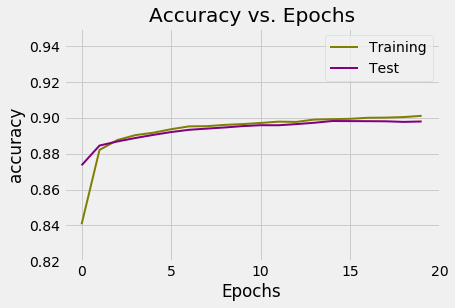

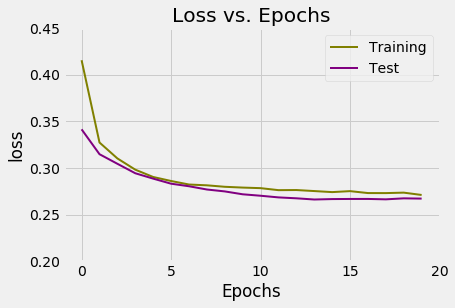

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt

print(model2.metrics_names)
plt.style.use('fivethirtyeight')

# Train accuracy
print(history[0].history.keys())

plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('accuracy')


plt.axis([-1, len(acc_log), 0.82, 0.95])
plt.plot(range(len(acc_log)), acc_log, color='olive', linewidth=2, label="Training")
plt.plot(range(len(acc_test)), acc_test, color='purple', linewidth=2, label="Test")
plt.legend()
plt.show()

print()

# Train loss
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

plt.axis([-1, len(loss_log), 0.20, 0.45])
plt.plot(range(len(loss_log)), loss_log, color='olive', linewidth=2, label="Training")
plt.plot(range(len(loss_test)), loss_test, color='purple', linewidth=2, label="Test")
plt.legend()
plt.show()

In [0]:
# Mount GDrive Data

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# ************************************************************
# *******************  TEST MODEL  ***************************
# ************************************************************

import numpy as np
import nltk
import tensorflow as tf
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.optimizers import RMSprop

# Load models
model1 = load_model('/content/gdrive/My Drive/datasets/PM_ESCIM19_DB3_N1.h5')
model1.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['sparse_categorical_accuracy'])

model2 = load_model('/content/gdrive/My Drive/datasets/PM_ESCIM19_DB3_N2.h5')
model2.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['sparse_categorical_accuracy'])

# Load dictionaries
word_index = np.load('/content/gdrive/My Drive/datasets/word_index_db3.npy', allow_pickle=True).item()
pos_index = np.load('/content/gdrive/My Drive/datasets/pos_index_db3.npy', allow_pickle=True).item()
sp_index = np.load('/content/gdrive/My Drive/datasets/sp_index_db3.npy', allow_pickle=True).item()


In [0]:
sentence = "I am surprised".split()

s_int = []
sentence_X = []

for word in sentence:
    try:
        s_int.append(word_index[word.lower()])
    except KeyError:
        s_int.append(word_index['-PAD-'.lower()])
sentence_X = s_int

print(sentence_X)

[8, 221, 2872]


In [0]:
sentence_X = np.array(sentence_X)

predictions = model1.predict(sentence_X.reshape(1, len(sentence_X), 1))

def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])
 
        token_sequences.append(token_sequence)
 
    return token_sequences

magic1 = logits_to_tokens(predictions, {i: t for t, i in pos_index.items()})

magic1[0] = [magic1[0][i].upper() for i in range(len(magic1[0]))]

print("Input test sentence:", sentence)
print("Predict. 1st network:", magic1[0])

pos_comp = nltk.pos_tag(sentence)

for i in range(len(pos_comp)):
  pos_comp[i] = pos_comp[i][1]

print("NLTK POS tagger: ", pos_comp)

Input test sentence: ['I', 'am', 'surprised']
Predict. 1st network: ['PRP', 'VBP', 'JJ']
NLTK POS tagger:  ['PRP', 'VBP', 'JJ']


In [0]:
print("Workd tokenize: ", nltk.word_tokenize("I am surprised"))

Workd tokenize:  ['I', 'am', 'surprised']


In [0]:
print("NLTK POS tagger: ", nltk.pos_tag(sentence))

NLTK POS tagger:  [('I', 'PRP'), ('am', 'VBP'), ('surprised', 'JJ')]


In [0]:
import nltk 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
sentence_pos = magic1[0]

s_int = []
sentence_X = []

for word in sentence_pos:
    try:
        s_int.append(pos_index[word.lower()])
    except KeyError:
        s_int.append(pos_index['-PAD-'.lower()])
sentence_X = s_int

print(sentence_X)

[5, 12, 6]


In [0]:
sentence_X = np.array(sentence_X)

predictions = model2.predict(sentence_X.reshape(1, len(sentence_X), 1))

def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])
 
        token_sequences.append(token_sequence)
 
    return token_sequences

magic2 = logits_to_tokens(predictions, {i: t for t, i in sp_index.items()})

magic2[0] = [magic2[0][i].upper() for i in range(len(magic2[0]))]

print(sentence)
print(magic2[0])


['I', 'am', 'surprised']
['NP', 'VP', 'VP']


In [0]:
for i, word in enumerate(sentence):
  print(word, " - ", end='')
  print(magic1[0][i], " - ", end='')
  print(magic2[0][i])

I  - PRP  - NP
am  - VBP  - VP
surprised  - JJ  - VP
